In [1]:
# this file contains code for creating mock-up stations
# elevation is calculated by linear interpolation of actual data

In [34]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate
from copy import deepcopy
from matplotlib import collections as mc

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS
from math import pi as PI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
test_months = [(1948, 1), (2012, 12)]

In [3]:
df_locations = pd.read_csv(f"{BASE_DIR}/SKNlocations.csv")

In [4]:
def get_convexhull_coords(df_locations, lat_range, lon_range):
    resolution = 200
    df_locations_island = df_locations[
        (df_locations["Lat_DD"] > lat_range[0]) &
        (df_locations["Lat_DD"] < lat_range[1]) &
        (df_locations["Lon_DD"] > lon_range[0]) &
        (df_locations["Lon_DD"] < lon_range[1])
    ]
    
    station_coords_island = df_locations_island[["Lon_DD", "Lat_DD"]].to_numpy()
    # find points that are inside the island convex hull
    hull = Delaunay(station_coords_island)
    xx, yy = np.meshgrid(np.linspace(*lon_range, resolution), np.linspace(*lat_range, resolution))
    candidate_coords = np.dstack((xx.flatten(), yy.flatten())).reshape(-1,2)
    idx_in = hull.find_simplex(candidate_coords)
    coords_in = candidate_coords[np.where(idx_in > -1)[0]]
    return coords_in

In [5]:
lon_oahu = (-157.966174-0.45, -157.966174+0.45)
lat_oahu = (21.485495-0.45, 21.485495+0.45)

island_ranges = [
    {
        "name": "kauai",
        "lat": (22.066281-0.45, 22.066281+0.45),
        "lon": (-159.526021-0.45, -159.526021+0.45)
    },
    {
        "name": "oahu",
        "lat": (21.485495-0.45, 21.485495+0.45),
        "lon": (-157.966174-0.45, -157.966174+0.45)
    },
    {
        "name": "molokai",
        "lat": (21.134806-0.15, 21.134806+0.15),
        "lon":  (-157.015431-0.35, -157.015431+0.35),
    },
    {
        "name": "lanai",
        "lat": (20.829217-0.1, 20.829217+0.1),
        "lon": (-156.926489-0.15, -156.926489+0.15),
    },
    {
        "name": "maui",
        "lat": (20.820998-0.24, 20.820998+0.24),
        "lon": (-156.312097-0.45, -156.312097+0.45)
    },
    {
        "name": "kahoolawe",
        "lat": (20.548690-0.1, 20.548690+0.1),
        "lon": (-156.608597-0.1, -156.608597+0.1)
    },
    {
        "name": "hawaii",
        "lat": (19.602708-0.7, 19.602708+0.7),
        "lon": (-155.474286-0.7, -155.474286+0.7)
    }
]

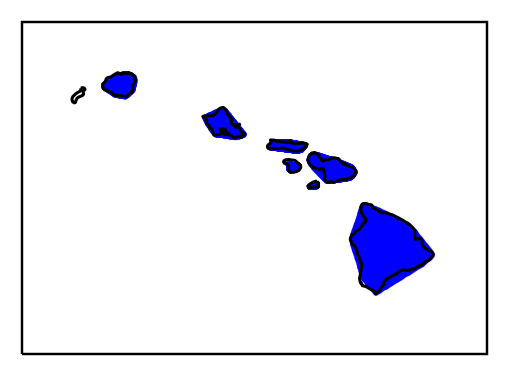

In [6]:
island_range = island_ranges[6]

xmin, xmax = -161, -154
ymin, ymax = 18, 23

fig, ax = plt.subplots(
    1, 1, figsize=(3, 2), dpi=220,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
        'xlim': (xmin, xmax),
        'ylim': (ymin, ymax)
    },
    gridspec_kw={
        "hspace": 0.1
    }
)

for island_range in island_ranges:
    test = get_convexhull_coords(
        df_locations,
        island_range['lat'], 
        island_range['lon'])
    ax.scatter(test[:, 0], test[:, 1], s=0.1, facecolor='b', edgecolor='b', alpha=0.5)

ax.coastlines(resolution='10m')

In [30]:
lat = np.arange(17.5, 27.5, 2.5)
lon = np.arange(195, 207.5, 2.5)

xx, yy = np.meshgrid(lat, lon)
grids = np.dstack((xx.flatten(), yy.flatten())).reshape(-1,2)

def closest_grid(target, grids):
    idx = np.linalg.norm(grids - target, axis=1).argmin()
    return grids[idx]

In [8]:
df_locations["Lon_DD_updated"] = df_locations.apply(lambda row: row['Lon_DD'] + 360, axis=1)

In [53]:
test_coords = df_locations[["Lat_DD", "Lon_DD_updated"]].to_numpy()

lines = []
for target in test_coords:
    closest = closest_grid(target, grids)
    lines.append([(closest[1]-360, closest[0]), (target[1]-360, target[0])])

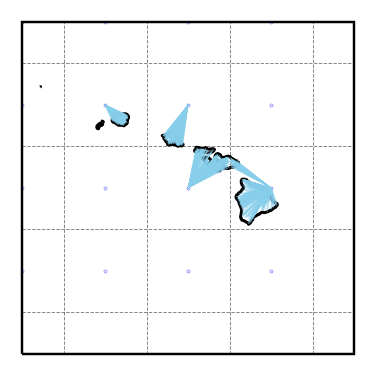

In [63]:
island_range = island_ranges[6]

xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

fig, ax = plt.subplots(
    1, 1, figsize=(3, 2), dpi=220,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
        'xlim': (xmin, xmax),
        'ylim': (ymin, ymax)
    },
    gridspec_kw={
        "hspace": 0.1
    }
)

lc = mc.LineCollection(lines, colors="skyblue", linewidth=0.1)
ax.scatter(grids[:, 1]-360, grids[:, 0], s=0.05, facecolor='b', edgecolor='b', alpha=0.5)

plt.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=0.3, linestyle="--", alpha=0.5)
plt.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=0.3, linestyle="--", alpha=0.5)
ax.add_collection(lc)
ax.coastlines(resolution='10m')